# Интро

Целью данного проекта является построение модели нейронной сети, которая отслеживает движение глаз.

План работы:

1. Создание датасета (Таким же способом, какой использовали при создании модели по остлеживанию лица (с помощью сбора данных с камеры, аннотации с помощью labelme)). Разница в том, что в данном случае вместо создания лейбла рамки, мы создадим лейбл точки на каждый глаз.


2. В прошлый раз вместо основной модели мы использовали VGG16 модель, убрав из нее верхние слои. В этот раз мы также будем использовать в качестве основной модели модель RESNET. 


3. В качестве аутпута для модели будет выступать координаты x и у для правого и x и у для левого глаза. 


4. В качестве функции потерь мы будем использовать MSE, так как мы решаем проблему регрессии (насколько близко точки, которые дает модель на аутпуте подходят к реальным точкам глах).

# Установка окружения

In [2]:
import os
import cv2
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=1)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

# Загрузка данных

## Подготовка изображений

Мы уже создали данные в отдельной тетради. Это сделано в целях отсутствия пересоздания данных в случае повторного включения тетради.

In [5]:
#функция для загрузки изображения
#мы написали данную функцию, т.к. мы не можем просто просмотреть images[i] файл 
def load_image(x): 
    byte_img = tf.io.read_file(x) #кодируем изображение в байты
    img = tf.io.decode_jpeg(byte_img) #получаем изображение обратно в виде array 
    return img

Загрузка датасета в TensorFlow

In [6]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False) #берем изображения из папки
#в строчке выше указывается только путь к изображению, а строчка ниже конвертирует изображение в array
train_images = train_images.map(load_image) #кодируем изображения в array
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250))) #изменяем размер изображения
#это делает как для того, чтобы уменьшить вес данных, так и для того, чтобы выборка была более генерализированна
train_images = train_images.map(lambda x: x/255) #нормализуем изображения как для того, чтобы не увеличивались весы, так
# и для того, чтобы сигмойдная функция активации работала должным образом
#Мы уменьшаем размер данны таким образом, чтобы мы могли увеличить размер батча, что позволяет ускорить обучение и помогает
#регуляризации

In [7]:
train_images.as_numpy_iterator().next().shape

(250, 250, 3)

In [8]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

In [9]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

## Подготовка лейблов

In [10]:
def load_labels(label_path):
    #загружаем файл
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    #возвращаем класс и координаты рамки
    return [label['keypoints']]

Важно, что у нас два класса. Левый и правый глаз. Словарь с лейблом (label_path) содержит упоминание о том, встретился ли класс. Если класс встретился, то 1 если не встретился, то 0. И так для каждого глаза. 

In [11]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False) #берем данные из папки
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16])) #для того, чтобы работать с операторами
#функций, такими как with нужно применить tf.py_function.

In [12]:
train_labels.as_numpy_iterator().next()
#координаты x, y, для левого и правого глаза: первые 2 - X и Y для левого глааз, вторые 2 X и Y для правого глаза

(array([0.54  , 0.4934, 0.3933, 0.4922], dtype=float16),)

In [13]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [14]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

## Собираем изображения и лейблы вместе и обробатываем

In [15]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(6720, 6720, 1440, 1440, 1440, 1440)

In [16]:
train = tf.data.Dataset.zip((train_images, train_labels)) #помещаем сэпмплы в zip с итерацией 
train = train.shuffle(8000) #шафлим данные (лучше, чтобы буфер для шафла был больше длины датасета)
train = train.batch(8) #делаем батчи в размере 16
train = train.prefetch(4)

In [17]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1500)
test = test.batch(8)
test = test.prefetch(4)

In [18]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1500)
val = val.batch(8)
val = val.prefetch(4)

## Осмотр данных

In [19]:
data_samples = train.as_numpy_iterator() #создадим итератор

In [20]:
res = data_samples.next() #поместим сэмпл в переменную

In [21]:
res[0].shape
#16 батчей, сэмплы 250 на 250 на 3 цвета 

(8, 250, 250, 3)

In [22]:
res[1] #здесь координаты точек

(array([[0.6123, 0.443 , 0.7456, 0.4465],
        [0.5107, 0.5415, 0.3787, 0.539 ],
        [0.617 , 0.4805, 0.5015, 0.4792],
        [0.1943, 0.4167, 0.0798, 0.3982],
        [0.537 , 0.4905, 0.678 , 0.4824],
        [0.5186, 0.5234, 0.3936, 0.5176],
        [0.4656, 0.4785, 0.3232, 0.475 ],
        [0.7295, 0.3975, 0.6265, 0.3823]], dtype=float16),)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


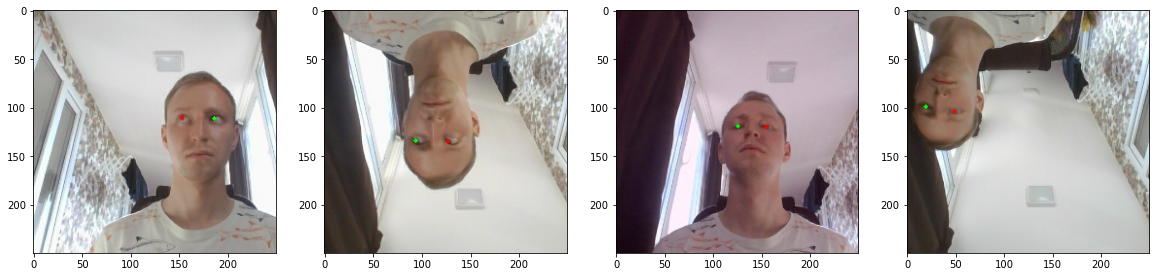

In [23]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][0][idx]
    
    #рисуем точки. 
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), #умножаем первые две координаты
               #(левый глаз) на 250,250, выводя значения из нормализации. Конвертируем в int, чтобы взять целое число
               #для того, чтобы нормально отрисовать точку. Помещаем в tuple по требованию openCV
               2, #ширина точки
               (255,0,0), #RGB - R первый, значит будет красная точка
               -1) #заполняет круг полностью внутри контура
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image) #выводим изображение

# Создание модели 

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.applications import ResNet152V2 
from tensorflow.keras.applications import VGG16

ResNet152V2 - это уже существующая модель с настроенными весами, которая изготовлена для подобных задач

In [25]:
# ResNet152V2(include_top=False)(Input(shape=(250, 250, 3)))
# #Получаем информацию о том какой аутпут дает слой по форме. Первое - это размер батча, 8 на 8 - размер изображения
# #2048 - юниты 

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'resnet152v2')>

In [26]:
model = Sequential([
    Input(shape=(250,250,3)), #на вход поступает изображение 250 по длине и ширине и на 3 канала 
    VGG16(include_top=False, input_shape=(250,250,3)), #include_top=False, т.к. нам нужны только первые слои, 
    #нам не нужны слои классификации, которые включает в себя модель, мы их сделаем сами
    #Сейчас нужно изменить форму инпута так, чтобы выходная форма была 4
    #Для этого следующие слои нам нужно продумать с умом. Определить кол-во фильтров в них и кол-во шагов в фильтрах
    #Первый аргумнет - кол-во фильтров, второй размер фильтра (3 на 3 окна), третий арг (числовой) шаги - то есть сколько шагов
    #делает фильтр в окне. В последних двух слоях вместо того, чтобы двигаться на каждый пиксель, мы будет двигаться через 2 пикселя
    #В summary можно посмотреть как какой-либо параметр изменяет кол-во выходов
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(128, 2, 2, padding='same', activation='relu'),
    Conv2D(128, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    Reshape((4,))
])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 512)         2359808   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 512)         2359808   
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         262272    
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 128)         65664     
                                                                 
 dropout (Dropout)           (None, 2, 2, 128)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 4)           2

## Инициализируем оптимайзер

In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError() 

In [29]:
model.compile(optimizer, loss)

## Сырые прогнозы

In [30]:
X, y = train.as_numpy_iterator().next()

In [31]:
X.shape

(8, 250, 250, 3)

In [32]:
scores = model.predict(X)

1/1 [==============================] - 12s 12s/step


In [33]:
scores

array([[ 0.4256875 , -0.15284766, -0.1077641 , -0.01592092],
       [ 0.29293618, -0.14105994, -0.17955455, -0.0376032 ],
       [ 0.24459234, -0.09902661, -0.10383403, -0.03021209],
       [ 0.2941861 , -0.18704514, -0.2295173 , -0.02039925],
       [ 0.3692083 , -0.01400493, -0.10935599, -0.01263242],
       [ 0.2770966 , -0.10024396, -0.18574382, -0.1293619 ],
       [ 0.1948418 , -0.11882266, -0.21119286, -0.10260474],
       [ 0.281846  , -0.05598978, -0.11317972, -0.03699304]],
      dtype=float32)

# Тренировка модели

In [34]:
# hist = model.fit(train, epochs=5, validation_data=val)

In [35]:
# #сохраним словарь hist, хранящий инфо об обучении
# np.save('eyetracking_hist.py', dictionary)

In [37]:
hist = np.load('eyetracking_hist.py.npy', allow_pickle=True).item()

In [38]:
# model.save('eyetracking_model')

In [40]:
model = tf.keras.models.load_model('eyetracking_model.h5')

# Результаты обучения

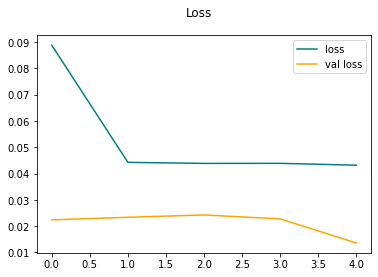

In [45]:
plt.plot(hist['loss'], color='teal', label='loss')
plt.plot(hist['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

Конечно, всего лишь 5 эпох на VGG16 - это не достаточно, чтобы построить действительно хорошую модель, однако даже 5 эпох показали достаточно неплохой результат на валидационной функции потерь.

Посмотрим как модель покажет себя на тестовых данных

In [50]:
test_data = test.as_numpy_iterator()

In [51]:
test_sample = test_data.next()

In [52]:
yhat = model.predict(test_sample[0])

1/1 [==============================] - 0s 40ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


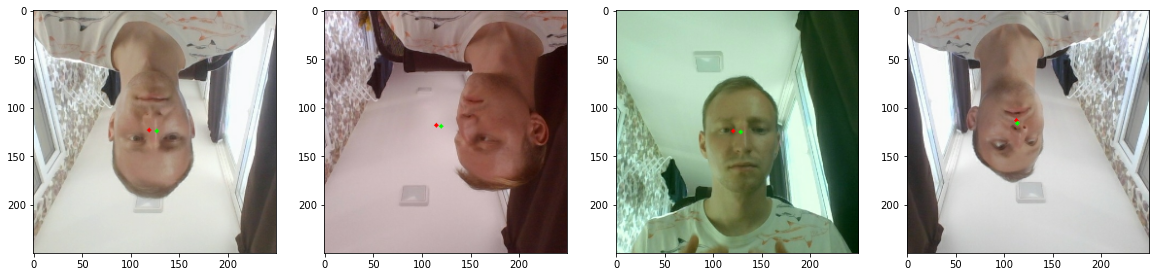

In [53]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

Как видно, точки стоят близко к глазам, однако не на самих зрачках. Стоит еще раз указать, что модель тренировалась всего лишь 5 эпох и для 5 эпох это достаточно хорошой результат. Стоило бы увеличить количество эпох, т.к. фунция потерь продолжала снижаться, но на данном девайсе прохождение 100 эпох займет около 5 часов.

# Детекция в реальном времени

In [54]:
cap = cv2.VideoCapture(0) 
while cap.isOpened():
    _ , frame = cap.read()
    
    frame = frame[50:500,50:500,:] #по дефолту 480*640 пикселей, но обрезаем, чтобы сделать более мелкую рамку, и чтобы подогнать
    #под модель сети на вход
    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) #изменяем цвет
    resized = cv2.resize(rgb_img, (250,250)) #уменьшаем вдвое изображение, что оно приобрело форму инпута для модели
    
    yhat = model.predict(np.expand_dims(resized/255,0)) #нормализуем и добавляем батч-измерение 
    sample_coords = yhat[0,:4] #берем предсказанные точки 
    
    cv2.circle(frame, tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(frame, tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 2, (0,255,0), -1)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
